In [1]:
# Libraries

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt # plots
import seaborn as sns # plots
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split # split data
from sklearn.model_selection import GridSearchCV
import itertools # aplanar arrays
import math
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve # ROC Curve
from sklearn.datasets import make_classification
import random
random.seed(1122019)
import pickle

from numpy import mean

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier

from sklearn import datasets
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from hyperopt import hp, STATUS_OK, fmin, tpe, Trials

from scipy import stats as sts 
import random

from numpy.ma import MaskedArray
import sklearn.utils.fixes
sklearn.utils.fixes.MaskedArray = MaskedArray
import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

The following variable indicates the route in which we have our dataset.

In [2]:
data_path = 'C:/Users/spnmlg/OneDrive - SAS/Desktop/folders/loan_csv.csv'

## 1. READING THE DATA

The dataset is kept into the data directory. In the same folder you can find the data dictionary.

In [3]:
loan = pd.read_csv(data_path)

C:\Users\spnmlg\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 2. SHOWING A PART OF THE DATASET AND EXPLORING IT 

In [4]:
# Set seed
random.seed(1122019)

In [5]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


The dataset has 145 variables and 1,332,021 samples of them because we have filtered the original dataset with SQLite to reduce the number of rows from 2,260,667 rows to 1,332,021.

In [6]:
loan.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,5550,5550,5550.0,36 months,15.02,192.45,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,2000,2000,2000.0,36 months,17.97,72.28,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,6000,6000,6000.0,36 months,13.56,203.79,C,C1,...,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,6000,6000,6000.0,36 months,14.47,206.44,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
type(loan)

pandas.core.frame.DataFrame

Tha dataset is a DataFrame.

## 3. CHOOSING VARIABLES

In [8]:
loan['loan_status'].value_counts(dropna=False)

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

At first we are going to create a target based on the loan status. We have deleted with SQLite the rows which are 'Current' and 'In Grace Period' in loan status. The samples which are 'Fully Paid' and 'Does not meet the credit policy. Status: Fully Paid' will be encode as 0, the rest of rows will be considered as a default and encoded as 1.

We have to run the following code instead of the previous if the dataset is not clean.

In [9]:
loan = loan[loan.loan_status != 'Current']
loan = loan[loan.loan_status != 'In Grace Period']
loan = loan[loan.loan_status != 'Does not meet the credit policy. Status:Fully Paid']
loan = loan[loan.loan_status != 'Does not meet the credit policy. Status:Charged Off']
loan = loan[loan.loan_status != 'Late (31-120 days)']
loan = loan[loan.loan_status != 'Late (16-30 days)']
loan['target'] = np.where(loan['loan_status'] == 'Fully Paid', 0, 1)

Now we delete the loan status variable.

In [10]:
del loan['loan_status']

In [11]:
len(loan)

1303638

The dataset has a lot of variables but some of then give us future information that, at the beggining, it´s supossed the bank would not have them. It is necessary to delete them, because if we include them in our model, we could be at risk of being introducting noise and over information.

In [12]:
loan['earliest_cr_line']

100        Jan-2012
152        Jun-2009
170        Feb-1999
186        Dec-2003
215        Oct-1997
             ...   
2260654    Dec-2001
2260655    Sep-2004
2260656    Dec-2000
2260658    Mar-2001
2260664    Mar-2003
Name: earliest_cr_line, Length: 1303638, dtype: object

We have realised that there are some information about bankcards, inquiries, installment andrevolving that coul be redundant. It will be calculated the correlation coefficient of the variables of that type of accounts.

In [13]:
bankcards = loan.loc[:,['bc_util','mths_since_recent_bc','mths_since_recent_bc_dlq','num_actv_bc_tl',
                      'num_bc_sats','num_bc_tl','percent_bc_gt_75','total_bc_limit','bc_open_to_buy']]

In [14]:
corr1 = bankcards.corr()
corr1

,bc_util,mths_since_recent_bc,mths_since_recent_bc_dlq,num_actv_bc_tl,num_bc_sats,num_bc_tl,percent_bc_gt_75,total_bc_limit,bc_open_to_buy
bc_util,1.000000,0.144307,0.034312,0.077326,-0.176566,-0.161544,0.844546,-0.252590,-0.545256
mths_since_recent_bc,0.144307,1.000000,-0.089394,-0.251729,-0.287557,-0.222152,0.149062,-0.085005,-0.112886
mths_since_recent_bc_dlq,0.034312,-0.089394,1.000000,-0.013541,-0.036438,0.022536,0.028671,-0.076636,-0.068663
num_actv_bc_tl,0.077326,-0.251729,-0.013541,1.000000,0.829054,0.577078,0.034186,0.465125,0.235364
num_bc_sats,-0.176566,-0.287557,-0.036438,0.829054,1.000000,0.717156,-0.170160,0.594630,0.466915
num_bc_tl,-0.161544,-0.222152,0.022536,0.577078,0.717156,1.000000,-0.149603,0.481708,0.401962
percent_bc_gt_75,0.844546,0.149062,0.028671,0.034186,-0.170160,-0.149603,1.000000,-0.215023,-0.442312
total_bc_limit,-0.252590,-0.085005,-0.076636,0.465125,0.594630,0.481708,-0.215023,1.000000,0.838558
bc_open_to_buy,-0.545256,-0.112886,-0.068663,0.235364,0.466915,0.401962,-0.442312,0.838558,1.000000


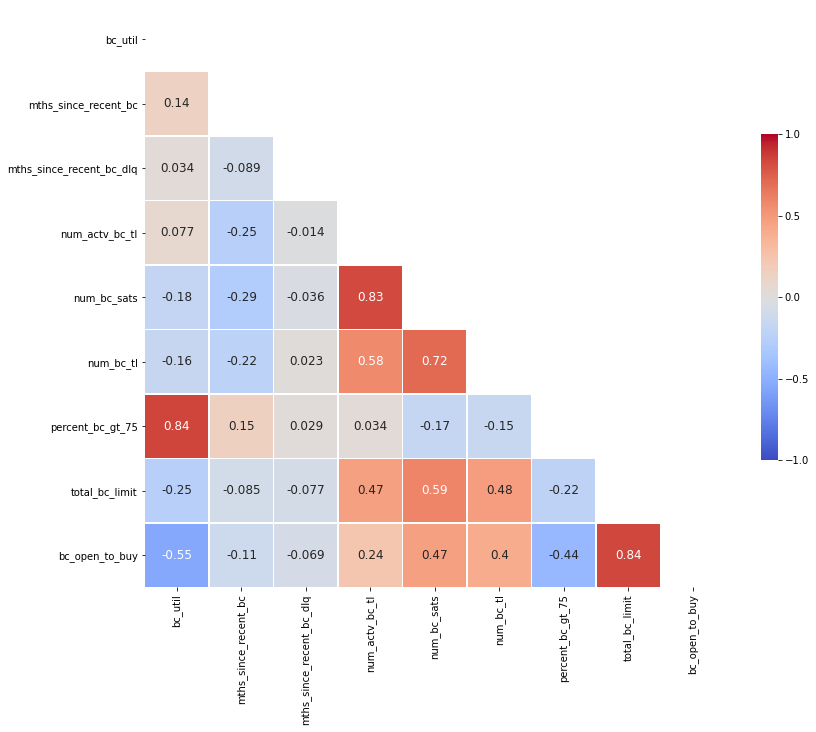

In [15]:
mask1 = np.zeros_like(corr1, dtype=np.bool)
mask1[np.triu_indices_from(mask1)]= True

f, ax = plt.subplots(figsize=(13, 15))
heatmap = sns.heatmap(corr1, 
                      square = True,
                      mask = mask1,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

ax.set_yticklabels(corr1.columns, rotation = 0)
ax.set_xticklabels(corr1.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [16]:
inquiries = loan.loc[:,['inq_fi','inq_last_6mths','inq_last_12m']]

In [17]:
corr2 = inquiries.corr()
corr2

,inq_fi,inq_last_6mths,inq_last_12m
inq_fi,1.000000,0.216065,0.563386
inq_last_6mths,0.216065,1.000000,0.480082
inq_last_12m,0.563386,0.480082,1.000000


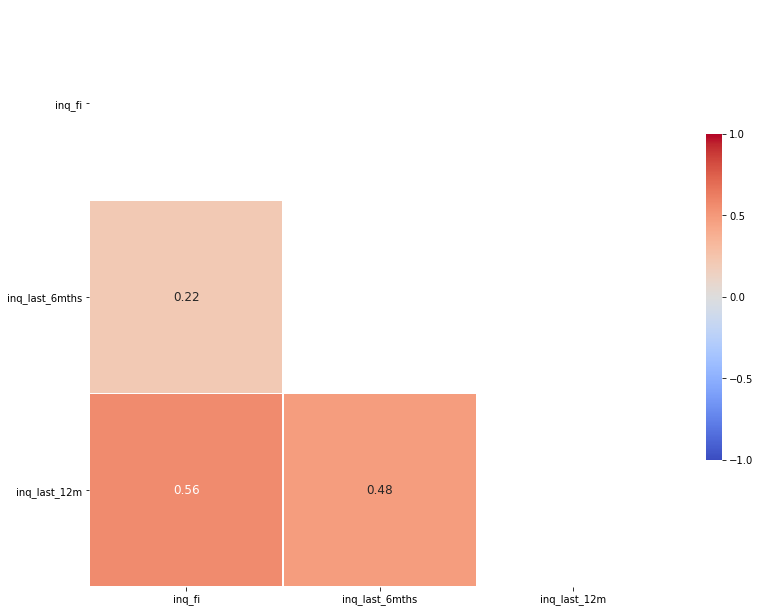

In [18]:
mask2 = np.zeros_like(corr2, dtype=np.bool)
mask2[np.triu_indices_from(mask2)]= True

f, ax = plt.subplots(figsize=(13, 15))
heatmap = sns.heatmap(corr2, 
                      square = True,
                      mask = mask2,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

ax.set_yticklabels(corr2.columns, rotation = 0)
ax.set_xticklabels(corr2.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

We can see that every sample of the variable 'inq_last_6m' is NaN, so I will delete it.

In [19]:
installments = loan.loc[:,['installment','mo_sin_old_il_acct','mths_since_rcnt_il','num_il_tl','open_il_12m',
                          'open_il_24m','open_act_il','total_bal_il','total_il_high_credit_limit']]

In [20]:
corr3 = installments.corr()
corr3

,installment,mo_sin_old_il_acct,mths_since_rcnt_il,num_il_tl,open_il_12m,open_il_24m,open_act_il,total_bal_il,total_il_high_credit_limit
installment,1.000000,0.102913,-0.016585,0.061727,0.013201,0.035494,0.025012,0.140005,0.184797
mo_sin_old_il_acct,0.102913,1.000000,0.062341,0.334085,0.039126,0.051994,0.144977,0.199253,0.202926
mths_since_rcnt_il,-0.016585,0.062341,1.000000,-0.244402,-0.440682,-0.476962,-0.220125,-0.242611,-0.261360
num_il_tl,0.061727,0.334085,-0.244402,1.000000,0.345795,0.470012,0.631896,0.581741,0.588277
open_il_12m,0.013201,0.039126,-0.440682,0.345795,1.000000,0.754617,0.271119,0.298675,0.284037
open_il_24m,0.035494,0.051994,-0.476962,0.470012,0.754617,1.000000,0.357278,0.367218,0.373077
open_act_il,0.025012,0.144977,-0.220125,0.631896,0.271119,0.357278,1.000000,0.556474,0.551286
total_bal_il,0.140005,0.199253,-0.242611,0.581741,0.298675,0.367218,0.556474,1.000000,0.957491
total_il_high_credit_limit,0.184797,0.202926,-0.261360,0.588277,0.284037,0.373077,0.551286,0.957491,1.000000


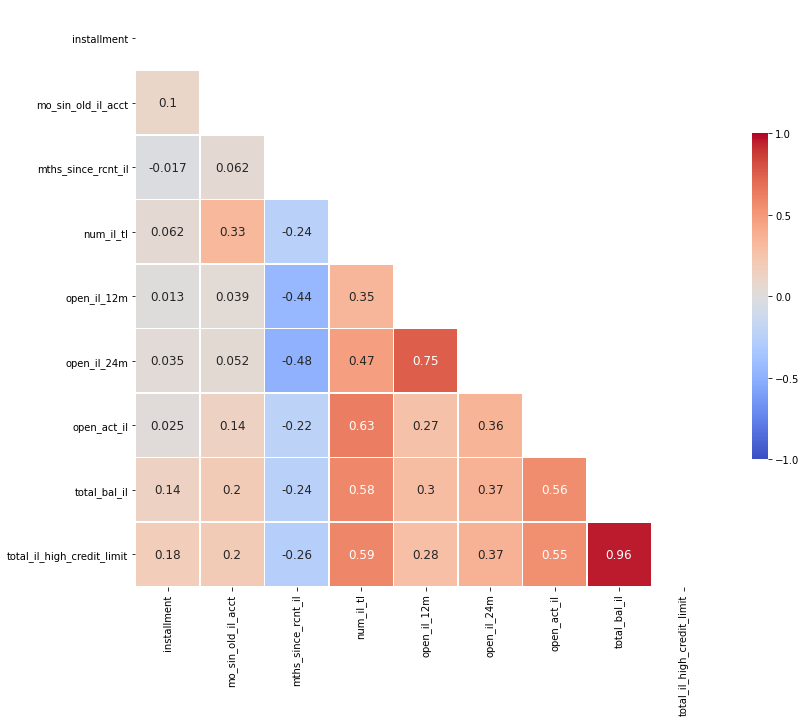

In [21]:
mask3 = np.zeros_like(corr3, dtype=np.bool)
mask3[np.triu_indices_from(mask3)]= True

f, ax = plt.subplots(figsize=(13, 15))
heatmap = sns.heatmap(corr3, 
                      square = True,
                      mask = mask3,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

ax.set_yticklabels(corr3.columns, rotation = 0)
ax.set_xticklabels(corr3.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

I realise that 'num_it_tl' is NaN.

In [22]:
revolvings = loan.loc[:,['max_bal_bc','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mths_since_recent_revol_delinq',
                        'num_actv_rev_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','open_rv_12m',
                        'open_rv_24m','revol_bal','revol_util','total_rev_hi_lim','revol_bal_joint']]

In [23]:
corr4 = revolvings.corr()
corr4

,max_bal_bc,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mths_since_recent_revol_delinq,num_actv_rev_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,open_rv_12m,open_rv_24m,revol_bal,revol_util,total_rev_hi_lim,revol_bal_joint
max_bal_bc,1.000000,0.214907,0.094752,-0.017324,0.128836,0.091931,0.117794,0.123679,-0.091278,-0.104699,0.556684,0.327430,0.475269,0.527607
mo_sin_old_rev_tl_op,0.214907,1.000000,0.065931,-0.008164,0.158807,0.194298,0.359017,0.155178,-0.018930,-0.048470,0.218822,0.006298,0.248325,0.205077
mo_sin_rcnt_rev_tl_op,0.094752,0.065931,1.000000,-0.062431,-0.230397,-0.284130,-0.239358,-0.227573,-0.467516,-0.457484,0.027416,0.176906,-0.044767,0.027091
mths_since_recent_revol_delinq,-0.017324,-0.008164,-0.062431,1.000000,-0.005585,-0.046165,-0.021473,-0.007709,0.075936,0.097227,-0.038301,0.024170,-0.059058,0.007582
num_actv_rev_tl,0.128836,0.158807,-0.230397,-0.005585,1.000000,0.790825,0.567199,0.982017,0.362932,0.455214,0.296293,0.106197,0.304439,0.314485
num_op_rev_tl,0.091931,0.194298,-0.284130,-0.046165,0.790825,1.000000,0.774148,0.795138,0.452539,0.581837,0.233370,-0.206012,0.405640,0.260878
num_rev_accts,0.117794,0.359017,-0.239358,-0.021473,0.567199,0.774148,1.000000,0.563570,0.374753,0.475836,0.213231,-0.178463,0.355510,0.249527
num_rev_tl_bal_gt_0,0.123679,0.155178,-0.227573,-0.007709,0.982017,0.795138,0.563570,1.000000,0.350819,0.445990,0.296094,0.115472,0.302262,0.315243
open_rv_12m,-0.091278,-0.018930,-0.467516,0.075936,0.362932,0.452539,0.374753,0.350819,1.000000,0.774346,-0.003565,-0.198108,0.119596,-0.021321
open_rv_24m,-0.104699,-0.048470,-0.457484,0.097227,0.455214,0.581837,0.475836,0.445990,0.774346,1.000000,0.001171,-0.216035,0.144496,-0.005650


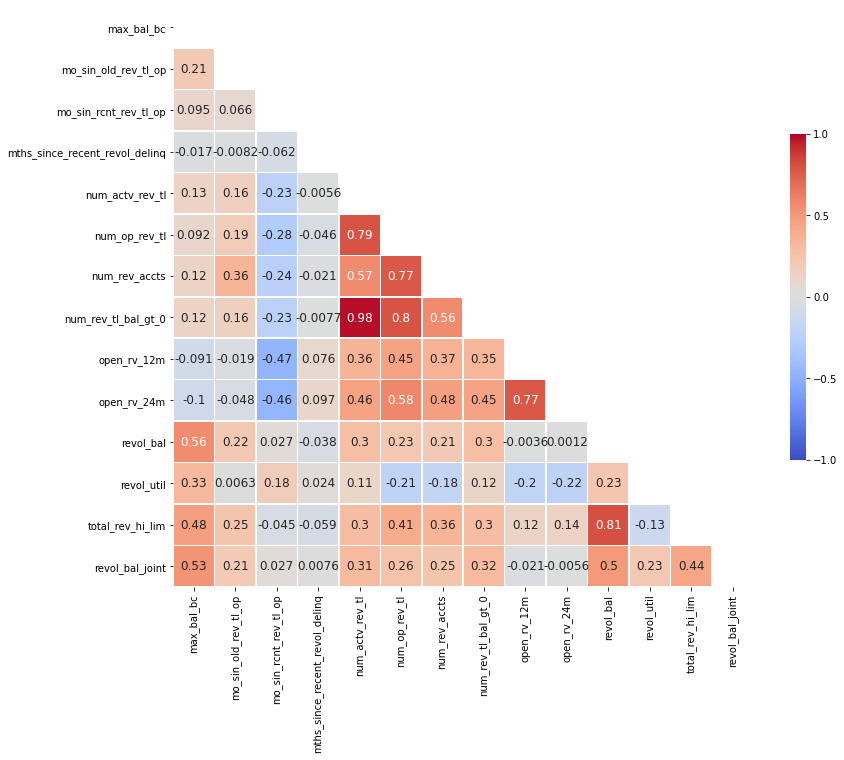

In [24]:
mask4 = np.zeros_like(corr4, dtype=np.bool)
mask4[np.triu_indices_from(mask4)]= True

f, ax = plt.subplots(figsize=(13, 15))
heatmap = sns.heatmap(corr4, 
                      square = True,
                      mask = mask4,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

ax.set_yticklabels(corr4.columns, rotation = 0)
ax.set_xticklabels(corr4.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

Now we know we have to delete 'num_rev_tl_bal_gt_o' or 'num_act_rev_tl'. I delete the second variable because it gives us less knowledge about the target. That variable gives us information about the trades with a balance over zero.

In [25]:
del loan['num_rev_tl_bal_gt_0']

In order to clean the dataset, the next step will be prove how many NaN we have it.

In [26]:
percentage_NaN = loan.apply(lambda x: sum(x.isna()/len(loan)))
percentage_NaN.sort_values(ascending = False).head(40)

id                                            1.000000
member_id                                     1.000000
url                                           1.000000
next_pymnt_d                                  0.999976
orig_projected_additional_accrued_interest    0.997367
hardship_end_date                             0.995908
payment_plan_start_date                       0.995908
hardship_length                               0.995908
hardship_dpd                                  0.995908
hardship_loan_status                          0.995908
hardship_last_payment_amount                  0.995908
hardship_payoff_balance_amount                0.995908
hardship_amount                               0.995908
deferral_term                                 0.995908
hardship_status                               0.995908
hardship_reason                               0.995908
hardship_type                                 0.995908
hardship_start_date                           0.995908
sec_app_mt

## 4. FILTERING DATA

We want to keep the biggest number of variables at the beggining, because the more number of variables you have, the more possibilities you have to generate a better prediction model. In order to continue with that philosophy, we will only delete the variables with a percentage over the 95%.

In [27]:
NaN = pd.DataFrame(round(loan.isnull().sum()/len(loan.index)*100,2),columns=['null_percent'])

In [28]:
Filtro = NaN['null_percent']>95
Nulls = NaN[Filtro]
loan_filtered = loan.drop(list(Nulls.index), axis=1)

We check the dimension of the dataset.

In [29]:
loan_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303638 entries, 100 to 2260664
Columns: 106 entries, loan_amnt to target
dtypes: float64(79), int32(1), int64(4), object(22)
memory usage: 1.0+ GB


The percentage of NaN is the following.

In [30]:
percentage_NaN = loan_filtered.apply(lambda x: sum(x.isna()/len(loan_filtered)))
percentage_NaN.sort_values(ascending = False).head(40)

desc                              0.905398
mths_since_last_record            0.829881
mths_since_recent_bc_dlq          0.762851
mths_since_last_major_derog       0.737367
il_util                           0.668087
mths_since_recent_revol_delinq    0.665667
mths_since_rcnt_il                0.626753
all_util                          0.616822
inq_last_12m                      0.616784
total_cu_tl                       0.616784
open_acc_6m                       0.616784
open_il_24m                       0.616783
open_rv_12m                       0.616783
open_rv_24m                       0.616783
max_bal_bc                        0.616783
open_il_12m                       0.616783
inq_fi                            0.616783
total_bal_il                      0.616783
open_act_il                       0.616783
mths_since_last_delinq            0.504613
mths_since_recent_inq             0.130061
num_tl_120dpd_2m                  0.088653
mo_sin_old_il_acct                0.080003
emp_title  

We will proceed with the attribution of the NaN, some of those variables could have a NaN as value due to the inexistance of that type of account, so the correctly assignment will be give them a zero or calculateing the maximum. 

Values will be zero due to the customer has never done that action or now he/she is not commiting it and if he/she has not that type of account at this moment or or he/she has never had that type of account.

* 'il_util', ratio of total current balance to high credit/credit limit on all install account. 
* 'all_util', balance to credit limit on all trades. 
* 'inq_last_12m', number of credit inquiries in past 12 months. 
* 'total_cu_tl', number of finance trades.
* 'open_acc_6m', number of open trades in last 6 months.
* 'open_act_il', number of currently active installment trades.
* 'inq_fi', number of personal finance inquiries.
* 'max_bal_bc', maximum current balance owed on all revolving accounts.
* 'open_rv_12m', number of revolving trades opened in past 12 months.
* 'open_rv_24m', number of revolving trades opened in past 24 months.
* 'total_bal_il', total current balance of all installment accounts.
* 'open_il_12m', number of installment accounts opened in past 12 months.
* 'open_il_24m', number of installment accounts opened in past 24 months.

There are other kind of variables that they will be enconding calculateing the maximum of them.

* 'mths_since_last_record', the number of months since the last public record.
* 'mths_since_recent_bc_dlq', months since most recent bankcard delinquency,
* 'mths_since_recent_revol_delinq', months since most recent revolving delinquency.
* 'mths_since_rcnt_il', months since most recent installment accounts opened.
* 'mths_since_last_delinq', the number of months since the borrower's last delinquency.
* 'mths_since_recent_inq', months since most recent inquiry.

In [31]:
def fill_w_0(data, column):
    data[column].fillna(0, inplace = True)

In [32]:
def fill_max(data, column):
    data[column].fillna(data[column].max(), inplace = True) 

In [33]:
# refilling with 0

fill_w_0(loan_filtered, 'il_util')
fill_w_0(loan_filtered, 'all_util')
fill_w_0(loan_filtered, 'inq_last_12m')
fill_w_0(loan_filtered, 'total_cu_tl')
fill_w_0(loan_filtered, 'open_acc_6m')
fill_w_0(loan_filtered, 'open_act_il')
fill_w_0(loan_filtered, 'inq_fi')
fill_w_0(loan_filtered, 'max_bal_bc')
fill_w_0(loan_filtered, 'open_rv_12m')
fill_w_0(loan_filtered, 'open_rv_24m')
fill_w_0(loan_filtered, 'total_bal_il')
fill_w_0(loan_filtered, 'open_il_12m')
fill_w_0(loan_filtered, 'open_il_24m')

In [34]:
# refilling with the maximum

fill_max(loan_filtered, 'mths_since_last_record')
fill_max(loan_filtered, 'mths_since_recent_bc_dlq')
fill_max(loan_filtered, 'mths_since_recent_revol_delinq')
fill_max(loan_filtered, 'mths_since_last_major_derog')
fill_max(loan_filtered, 'mths_since_rcnt_il')
fill_max(loan_filtered, 'mths_since_last_delinq')
fill_max(loan_filtered, 'mths_since_recent_inq')

Now the percentage of NaN is:

In [35]:
percentage_NaN = loan_filtered.apply(lambda x: sum(x.isna()/len(loan_filtered)))
percentage_NaN.sort_values(ascending = False).head(25)

desc                          0.905398
num_tl_120dpd_2m              0.088653
mo_sin_old_il_acct            0.080003
emp_title                     0.063347
emp_length                    0.057882
pct_tl_nvr_dlq                0.051917
avg_cur_bal                   0.051815
num_rev_accts                 0.051800
mo_sin_rcnt_rev_tl_op         0.051800
mo_sin_old_rev_tl_op          0.051800
mo_sin_rcnt_tl                0.051799
num_op_rev_tl                 0.051799
total_rev_hi_lim              0.051799
num_accts_ever_120_pd         0.051799
num_actv_bc_tl                0.051799
num_actv_rev_tl               0.051799
num_bc_tl                     0.051799
tot_cur_bal                   0.051799
num_il_tl                     0.051799
num_tl_30dpd                  0.051799
num_tl_90g_dpd_24m            0.051799
num_tl_op_past_12m            0.051799
tot_coll_amt                  0.051799
tot_hi_cred_lim               0.051799
total_il_high_credit_limit    0.051799
dtype: float64

Now, we are going to fill de NAs values of the 'desc' column with zeros. We will transform this column in a dummy variable, if we don´t have the description we will obtain a 0, if something was written at the description, we will obtain the value = 1.

In [36]:
loan_filtered['desc'].fillna(0, inplace = True)
loan_filtered['desc'] = np.where(loan_filtered['desc'] != 0, 1, 0)
loan_filtered['desc'].value_counts(normalize=True)

0    0.905398
1    0.094602
Name: desc, dtype: float64

We want to know hoy many samples have we got with NAs, so we will count the number rows with NAs.

In [37]:
len(loan_filtered) - len(loan_filtered.dropna())

247369

We have around 250 000 of rows with NAs.It represents aproximately the 19% of the rows.

Now we will create 2 distinct dataframes ir order to split numerical and categorical variables, we need to work in a different way with them.

In [38]:
numericas = loan_filtered.select_dtypes(include = [np.number])
categoricas = loan_filtered.select_dtypes(include = [np.object])

In [39]:
numericas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303638 entries, 100 to 2260664
Data columns (total 85 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   loan_amnt                       1303638 non-null  int64  
 1   funded_amnt                     1303638 non-null  int64  
 2   funded_amnt_inv                 1303638 non-null  float64
 3   int_rate                        1303638 non-null  float64
 4   installment                     1303638 non-null  float64
 5   annual_inc                      1303638 non-null  float64
 6   desc                            1303638 non-null  int32  
 7   dti                             1303326 non-null  float64
 8   delinq_2yrs                     1303638 non-null  float64
 9   inq_last_6mths                  1303637 non-null  float64
 10  mths_since_last_delinq          1303638 non-null  float64
 11  mths_since_last_record          1303638 non-null  float64
 12

In [40]:
categoricas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303638 entries, 100 to 2260664
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   term                  1303638 non-null  object
 1   grade                 1303638 non-null  object
 2   sub_grade             1303638 non-null  object
 3   emp_title             1221056 non-null  object
 4   emp_length            1228181 non-null  object
 5   home_ownership        1303638 non-null  object
 6   verification_status   1303638 non-null  object
 7   issue_d               1303638 non-null  object
 8   pymnt_plan            1303638 non-null  object
 9   purpose               1303638 non-null  object
 10  title                 1288212 non-null  object
 11  zip_code              1303637 non-null  object
 12  addr_state            1303638 non-null  object
 13  earliest_cr_line      1303638 non-null  object
 14  initial_list_status   1303638 non-null  object
 

In [41]:
categoricas.nunique()

term                         2
grade                        7
sub_grade                   35
emp_title               371436
emp_length                  11
home_ownership               6
verification_status          3
issue_d                    139
pymnt_plan                   1
purpose                     14
title                    61678
zip_code                   943
addr_state                  51
earliest_cr_line           738
initial_list_status          2
last_pymnt_d               134
last_credit_pull_d         139
application_type             2
hardship_flag                2
disbursement_method          2
debt_settlement_flag         2
dtype: int64

We impute the NaN of numeric variables by the mean of each variable.

In [42]:
numericas = numericas.apply(lambda x: x.replace("", np.nan))
numericas = numericas.apply(lambda x: x.fillna(x.mean()))

In [43]:
numericas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303638 entries, 100 to 2260664
Data columns (total 85 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   loan_amnt                       1303638 non-null  int64  
 1   funded_amnt                     1303638 non-null  int64  
 2   funded_amnt_inv                 1303638 non-null  float64
 3   int_rate                        1303638 non-null  float64
 4   installment                     1303638 non-null  float64
 5   annual_inc                      1303638 non-null  float64
 6   desc                            1303638 non-null  int32  
 7   dti                             1303638 non-null  float64
 8   delinq_2yrs                     1303638 non-null  float64
 9   inq_last_6mths                  1303638 non-null  float64
 10  mths_since_last_delinq          1303638 non-null  float64
 11  mths_since_last_record          1303638 non-null  float64
 12

We impute the NaN of categorical variables by the mode of each variable.

In [44]:
categoricas = categoricas.apply(lambda x: x.replace("", np.nan))
categoricas = categoricas.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [45]:
categoricas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303638 entries, 100 to 2260664
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   term                  1303638 non-null  object
 1   grade                 1303638 non-null  object
 2   sub_grade             1303638 non-null  object
 3   emp_title             1303638 non-null  object
 4   emp_length            1303638 non-null  object
 5   home_ownership        1303638 non-null  object
 6   verification_status   1303638 non-null  object
 7   issue_d               1303638 non-null  object
 8   pymnt_plan            1303638 non-null  object
 9   purpose               1303638 non-null  object
 10  title                 1303638 non-null  object
 11  zip_code              1303638 non-null  object
 12  addr_state            1303638 non-null  object
 13  earliest_cr_line      1303638 non-null  object
 14  initial_list_status   1303638 non-null  object
 

In [46]:
categoricas.nunique()

term                         2
grade                        7
sub_grade                   35
emp_title               371436
emp_length                  11
home_ownership               6
verification_status          3
issue_d                    139
pymnt_plan                   1
purpose                     14
title                    61678
zip_code                   943
addr_state                  51
earliest_cr_line           738
initial_list_status          2
last_pymnt_d               134
last_credit_pull_d         139
application_type             2
hardship_flag                2
disbursement_method          2
debt_settlement_flag         2
dtype: int64

In [47]:
loan_filtered = pd.concat([numericas, categoricas], axis = 1)

There are some variables wich have a lot of categories, more than we can deal with, so we will delete them. Another variables, due to a research, we discover that give us information wich we would not have when we were going to give a loan.

In [48]:
del loan_filtered['sub_grade']
del loan_filtered['emp_title']
del loan_filtered['issue_d']

# we can not use neither the zip code nor the state adress, so we will delete them of the model, but we will
# do a copy of them in a local variable

zip_code = loan_filtered['zip_code']
del loan_filtered['zip_code']

addr_state = loan_filtered['addr_state']
del loan_filtered['addr_state']

del loan_filtered['title']
del loan_filtered['last_credit_pull_d']
del loan_filtered['last_pymnt_d']
del loan_filtered['debt_settlement_flag']
del loan_filtered['total_pymnt']
del loan_filtered['total_pymnt_inv']
del loan_filtered['total_rec_int']
del loan_filtered['total_rec_late_fee']
del loan_filtered['total_rec_prncp']
del loan_filtered['last_pymnt_amnt']
del loan_filtered['out_prncp']
del loan_filtered['out_prncp_inv']
del loan_filtered['hardship_flag']
del loan_filtered['pymnt_plan']

In [49]:
loan_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303638 entries, 100 to 2260664
Data columns (total 87 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   loan_amnt                       1303638 non-null  int64  
 1   funded_amnt                     1303638 non-null  int64  
 2   funded_amnt_inv                 1303638 non-null  float64
 3   int_rate                        1303638 non-null  float64
 4   installment                     1303638 non-null  float64
 5   annual_inc                      1303638 non-null  float64
 6   desc                            1303638 non-null  int32  
 7   dti                             1303638 non-null  float64
 8   delinq_2yrs                     1303638 non-null  float64
 9   inq_last_6mths                  1303638 non-null  float64
 10  mths_since_last_delinq          1303638 non-null  float64
 11  mths_since_last_record          1303638 non-null  float64
 12

There is a variable which we consider of vital importance, 'earliest_cr_line' indicates when the borrower's credit file started, the longer is the credit file, the more we can trust in the borrower.

In [50]:
x = loan_filtered['earliest_cr_line'] # we do a copy

In [51]:
x = x.astype(str) # convert to string

In [52]:
len(x) # show the length

1303638

In [53]:
x = x.map(lambda x: x.split('-')) # splitting by the '-'

In [54]:
x.iloc[2] # show a sample

['Feb', '1999']

In [55]:
x.max()

['Sep', '2015']

In [56]:
# we calculate the length of the credit file substracting the currently year and the year the credit file was born

x = x.map(lambda x: 2019 - int(x[1]))

In [57]:
x # the final result

100         7
152        10
170        20
186        16
215        22
           ..
2260654    18
2260655    15
2260656    19
2260658    18
2260664    16
Name: earliest_cr_line, Length: 1303638, dtype: int64

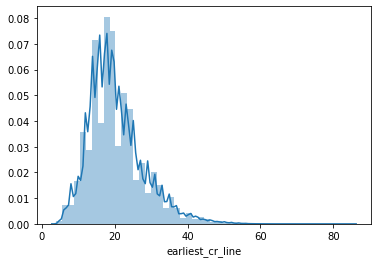

In [58]:
# histogram of credit file years

sns.distplot(x);

In [59]:
loan_filtered['earliest_cr_line'] = x # replacing the variable, now is numeric
del x

'home_ownership' has a lot of categories, when we will go to make dummies it will return us so many variables, in order to prevent it, we will reduce the dimension of this variable rencoding it.

In [60]:
loan_filtered['home_ownership'].value_counts()

MORTGAGE    645509
RENT        517821
OWN         139849
ANY            267
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

In [61]:
loan_filtered['home_ownership'] = np.where((loan_filtered['home_ownership'] != 'OWN') & (loan_filtered['home_ownership'] != 'RENT'),
                                    'OTHER', loan_filtered['home_ownership'].values)

In [62]:
loan_filtered['home_ownership'].value_counts()

OTHER    645968
RENT     517821
OWN      139849
Name: home_ownership, dtype: int64

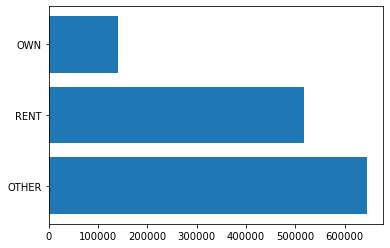

In [63]:
# barplot of homeownership

height = loan_filtered['home_ownership'].value_counts()
bars = ('OTHER', 'RENT', 'OWN')
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)
 
# Show graphic
plt.show()

The next step will be rencoding the variable 'emp_length', now we have 11 different values, we are going to rencode the variable ir order to have only 2 different values:
* From less than 1 year to 5 years.
* From 6 years to 10 years or more.

In [64]:
loan_filtered['emp_length'].value_counts()

10+ years    504010
2 years      117825
< 1 year     104552
3 years      104204
1 year        85678
5 years       81623
4 years       78033
6 years       60934
8 years       59127
7 years       58148
9 years       49504
Name: emp_length, dtype: int64

In [65]:
loan_filtered['emp_length'] = np.where((loan_filtered['emp_length'] == '< 1 year') | 
                                       (loan_filtered['emp_length'] == '1 year') |
                                       (loan_filtered['emp_length'] == '2 years') | 
                                       (loan_filtered['emp_length'] == '3 years') | 
                                       (loan_filtered['emp_length'] == '4 years') | 
                                       (loan_filtered['emp_length'] == '5 years'), 
                                       '<= 5 years', '6+ years')

We view the new values.

In [66]:
loan_filtered['emp_length'].value_counts()

6+ years      731723
<= 5 years    571915
Name: emp_length, dtype: int64

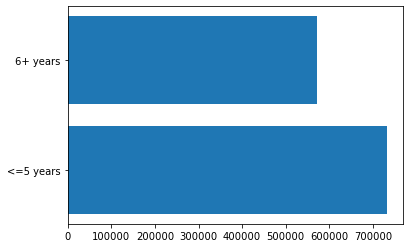

In [67]:
# barplot of emp_length

height = loan_filtered['emp_length'].value_counts()
bars = ('<=5 years', '6+ years')
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)
 
# Show graphic
plt.show()

In order to maintain the variable 'grade' and do not create as dummies as categories has the variable, we will apply an ordinal encondig to the variable. The method will be the following:
* We have 7 categories from best grade, 'A', to the worst grade 'G'.
* The order is A > B > C > D > E > F > G.
* The new encoding will be 6 > 5 > 4 > 3 > 2 > 1 > 0

In [68]:
loan_filtered['grade'].value_counts()

B    380158
C    369937
A    226245
D    195288
E     91574
F     31485
G      8951
Name: grade, dtype: int64

In [69]:
# first we create a mapper

mapper = {'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0}

# now we map the column and replace the values

loan_filtered['grade'] = loan_filtered['grade'].replace(mapper)

According to some financial papers, the loan purpose can serve as a method to decide the risk of the loan. We are going to see the different values of our variable 'purpose'.

In [70]:
loan_filtered['purpose'].value_counts()

debt_consolidation    757610
credit_card           285708
home_improvement       84497
other                  74937
major_purchase         28328
medical                15024
small_business         15010
car                    14121
moving                  9173
vacation                8732
house                   6967
wedding                 2294
renewable_energy         911
educational              326
Name: purpose, dtype: int64

How does affect the purpose in our target?

In [71]:
loan_filtered.groupby('purpose')['target'].value_counts()

purpose             target
car                 0          12053
                    1           2068
credit_card         0         237058
                    1          48650
debt_consolidation  0         596552
                    1         161058
educational         0            270
                    1             56
home_improvement    0          69410
                    1          15087
house               0           5454
                    1           1513
major_purchase      0          23024
                    1           5304
medical             0          11732
                    1           3292
moving              0           7022
                    1           2151
other               0          59070
                    1          15867
renewable_energy    0            695
                    1            216
small_business      0          10545
                    1           4465
vacation            0           7052
                    1           1680
wedding    

We need to reduce the number of types, so we will create new 6 new types in which they will be aggregate the currently types. 

* debt_consolidation: 'debt_consolidation'.
* home: which will include 'home_improvement', 'house' and 'moving'.
* purchase: includes 'credit_card', 'major_purchase', 'vacation', 'car' and 'wedding'.
* investment: includes 'small_business' and 'renewable_energy'.
* medical: 'medical'.
* other: includes 'other' and 'educational'.

In [72]:
# home

loan_filtered['purpose'] = np.where((loan_filtered['purpose'] == 'home_improvement') | 
                                    (loan_filtered['purpose'] == 'house') | 
                                    (loan_filtered['purpose'] == 'moving'), 
                                   'home', loan_filtered['purpose'].values)

In [73]:
# purchase

loan_filtered['purpose'] = np.where((loan_filtered['purpose'] == 'credit_card') | 
                                    (loan_filtered['purpose'] == 'major_purchase') | 
                                    (loan_filtered['purpose'] == 'vacation') | 
                                    (loan_filtered['purpose'] == 'wedding') |
                                    (loan_filtered['purpose'] == 'car'), 
                                   'purchase', loan_filtered['purpose'].values)

In [74]:
# investment

loan_filtered['purpose'] = np.where((loan_filtered['purpose'] == 'small_business') | 
                                    (loan_filtered['purpose'] == 'renewable_energy'), 
                                   'investment', loan_filtered['purpose'].values)

In [75]:
# other

loan_filtered['purpose'] = np.where((loan_filtered['purpose'] == 'other') | 
                                    (loan_filtered['purpose'] == 'educational'), 
                                   'other', loan_filtered['purpose'].values)

In [76]:
loan_filtered['purpose'].value_counts()

debt_consolidation    757610
purchase              339183
home                  100637
other                  75263
investment             15921
medical                15024
Name: purpose, dtype: int64

There are some variables in our dataset, e.g 'pymnt_plan' or 'hardship_flag', which by themselves are dummies, we only need to rencode them ir order to change their types from categorical to numeric.

In [77]:
loan_filtered.groupby('initial_list_status')['target'].value_counts()

initial_list_status  target
f                    0         443820
                     1         108580
w                    0         598132
                     1         153106
Name: target, dtype: int64

In [78]:
# fractioned

115046/(115046+445808)

0.20512646785081323

In [79]:
# whole

173035/(173035+598132)

0.22438071131155768

'initial_list_status' give us information about if the lending club offered the whole loan to the borrower or only a fraction of the loan. Independently of that, we want to know if the borrower will pay the loan. We do not mind if the loan was given fully or partially. Also, we can see that the percentage of defaults its similar in both types of status.

In [80]:
del loan_filtered['initial_list_status']

In [81]:
loan_filtered.groupby('disbursement_method')['target'].value_counts()

disbursement_method  target
Cash                 0         1037386
                     1          260439
DirectPay            0            4566
                     1            1247
Name: target, dtype: int64

In [82]:
# cash

286294/(286294+1039374)

0.21596206591695657

In [83]:
# direct pay

1787/(1787+4566)

0.28128443255155045

According to the same reason we delete 'disbursement_method'.

In [84]:
del loan_filtered['disbursement_method']

Due to all the transformations done, the index of the dataframe has changed and it does not follow the typical sequency of numbers, so we will reset the index to avoid future problems.

In [85]:
loan_filtered = loan_filtered.reset_index(drop = True)

In [86]:
categoricas = loan_filtered.select_dtypes(include = [np.object])
categoricas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303638 entries, 0 to 1303637
Data columns (total 6 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   term                 1303638 non-null  object
 1   emp_length           1303638 non-null  object
 2   home_ownership       1303638 non-null  object
 3   verification_status  1303638 non-null  object
 4   purpose              1303638 non-null  object
 5   application_type     1303638 non-null  object
dtypes: object(6)
memory usage: 59.7+ MB


In [87]:
numericas = loan_filtered.select_dtypes(include = [np.number])
numericas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303638 entries, 0 to 1303637
Data columns (total 79 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   loan_amnt                       1303638 non-null  int64  
 1   funded_amnt                     1303638 non-null  int64  
 2   funded_amnt_inv                 1303638 non-null  float64
 3   int_rate                        1303638 non-null  float64
 4   installment                     1303638 non-null  float64
 5   annual_inc                      1303638 non-null  float64
 6   desc                            1303638 non-null  int32  
 7   dti                             1303638 non-null  float64
 8   delinq_2yrs                     1303638 non-null  float64
 9   inq_last_6mths                  1303638 non-null  float64
 10  mths_since_last_delinq          1303638 non-null  float64
 11  mths_since_last_record          1303638 non-null  float64
 12  

At this moment we have our dataset clean, filtered and dimensionally reduced, so we can continue with other instances.

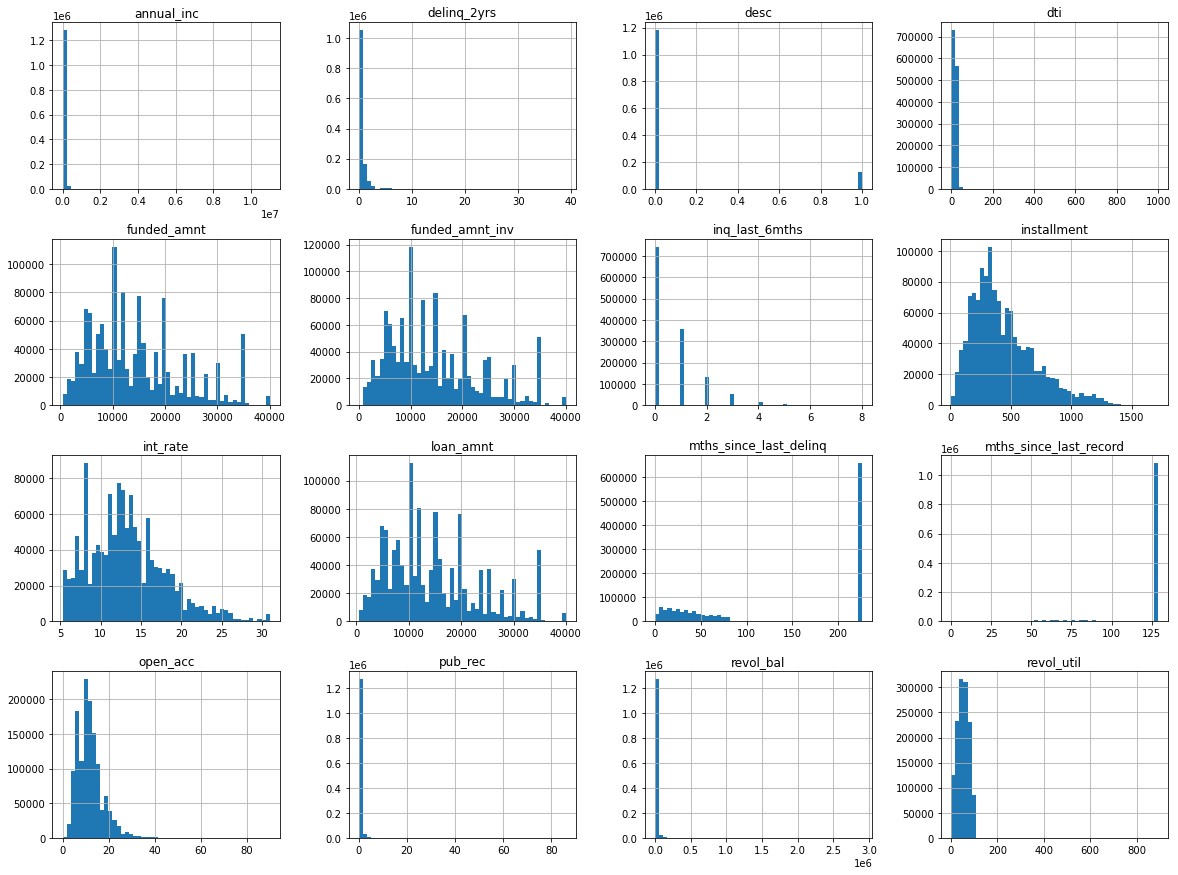

In [88]:
numericas.iloc[:,0:16].hist(bins=50, figsize=(20,15))
plt.show()

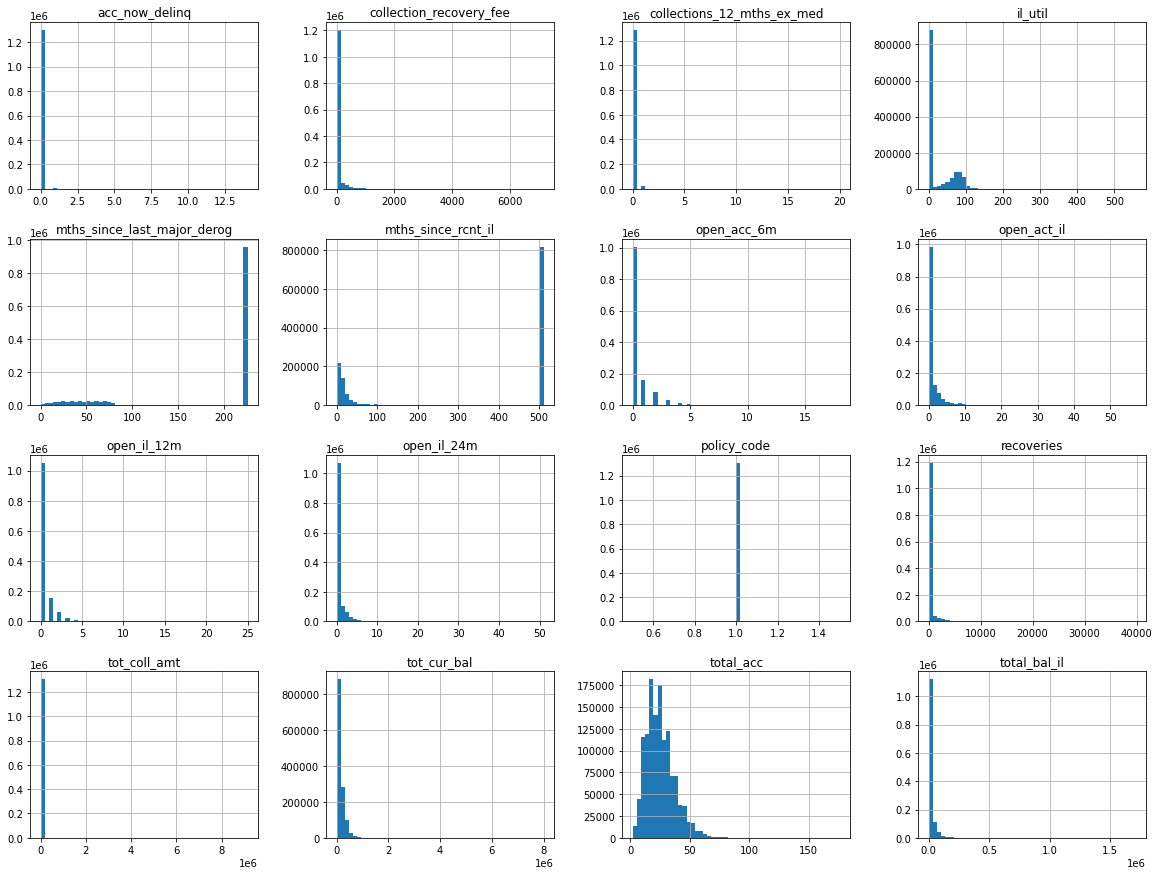

In [89]:
numericas.iloc[:,16:32].hist(bins=50, figsize=(20,15))
plt.show()

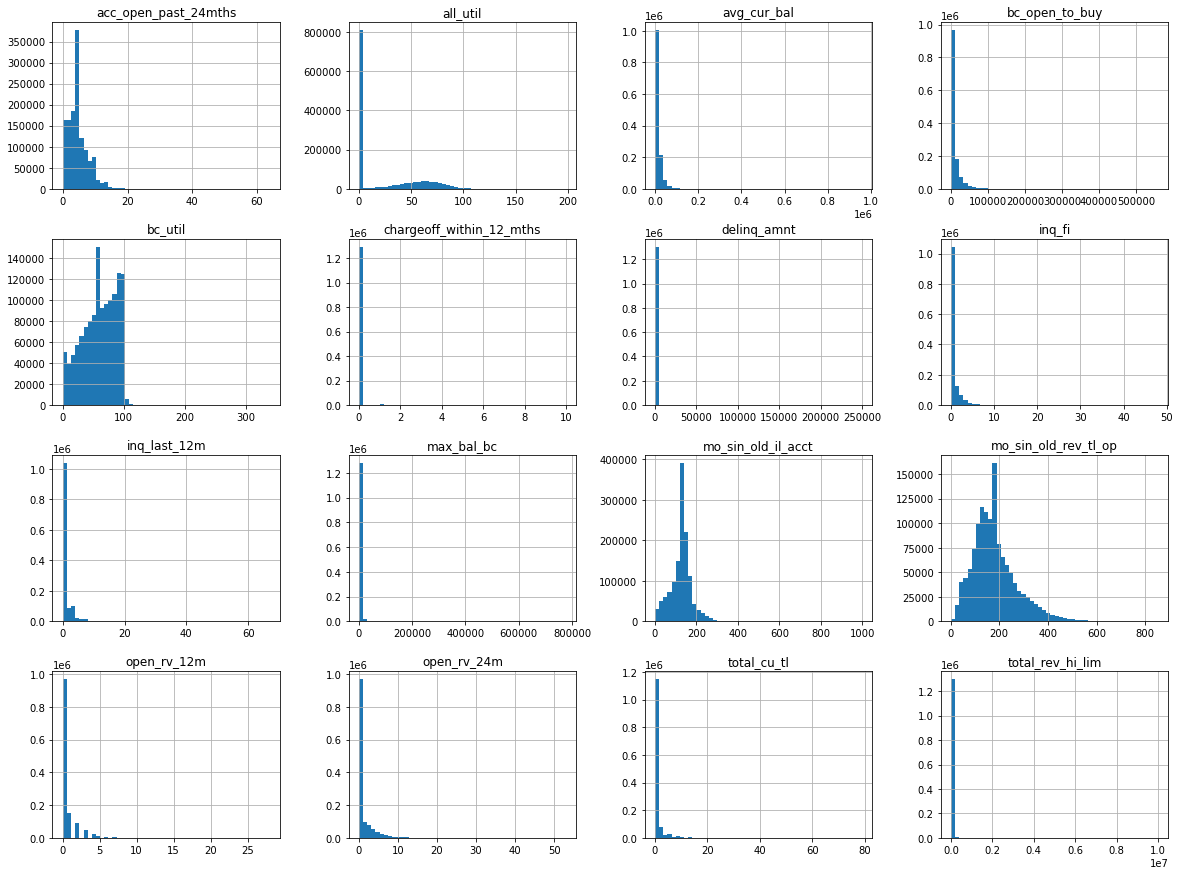

In [90]:
numericas.iloc[:,32:48].hist(bins=50, figsize=(20,15))
plt.show()

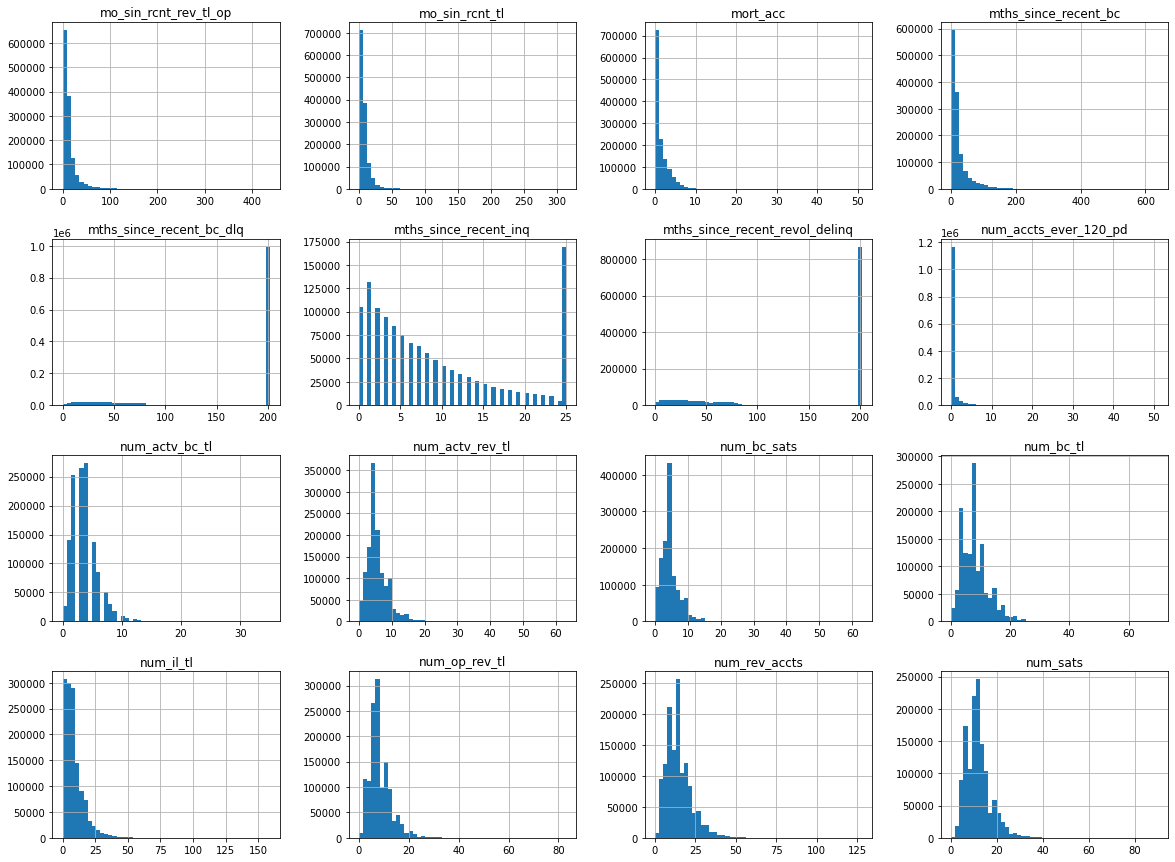

In [91]:
numericas.iloc[:,48:64].hist(bins=50, figsize=(20,15))
plt.show()

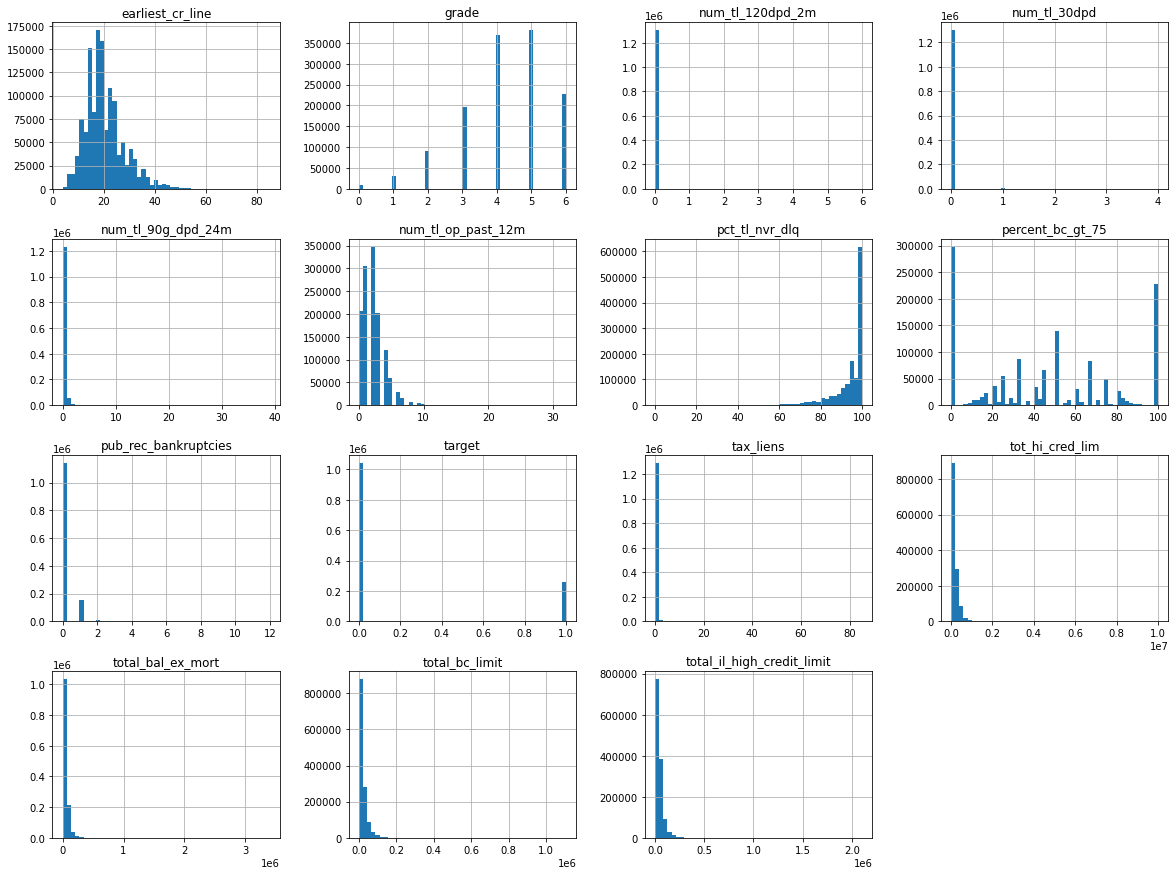

In [92]:
numericas.iloc[:,64:].hist(bins=50, figsize=(20,15))
plt.show()

In [93]:
numericas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303638 entries, 0 to 1303637
Data columns (total 79 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   loan_amnt                       1303638 non-null  int64  
 1   funded_amnt                     1303638 non-null  int64  
 2   funded_amnt_inv                 1303638 non-null  float64
 3   int_rate                        1303638 non-null  float64
 4   installment                     1303638 non-null  float64
 5   annual_inc                      1303638 non-null  float64
 6   desc                            1303638 non-null  int32  
 7   dti                             1303638 non-null  float64
 8   delinq_2yrs                     1303638 non-null  float64
 9   inq_last_6mths                  1303638 non-null  float64
 10  mths_since_last_delinq          1303638 non-null  float64
 11  mths_since_last_record          1303638 non-null  float64
 12  

In [94]:
categoricas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303638 entries, 0 to 1303637
Data columns (total 6 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   term                 1303638 non-null  object
 1   emp_length           1303638 non-null  object
 2   home_ownership       1303638 non-null  object
 3   verification_status  1303638 non-null  object
 4   purpose              1303638 non-null  object
 5   application_type     1303638 non-null  object
dtypes: object(6)
memory usage: 59.7+ MB


### 4.2 Making dummies 

These variables are going to be converted to dummies.

In [95]:
list(categoricas)

['term',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'application_type']

In [96]:
dummies = pd.get_dummies(categoricas)
dummies.head()

,term_ 36 months,term_ 60 months,emp_length_6+ years,emp_length_<= 5 years,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_debt_consolidation,purpose_home,purpose_investment,purpose_medical,purpose_other,purpose_purchase,application_type_Individual,application_type_Joint App
0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1
1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1
2,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1
3,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0
4,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1


In [97]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303638 entries, 0 to 1303637
Data columns (total 18 columns):
 #   Column                               Non-Null Count    Dtype
---  ------                               --------------    -----
 0   term_ 36 months                      1303638 non-null  uint8
 1   term_ 60 months                      1303638 non-null  uint8
 2   emp_length_6+ years                  1303638 non-null  uint8
 3   emp_length_<= 5 years                1303638 non-null  uint8
 4   home_ownership_OTHER                 1303638 non-null  uint8
 5   home_ownership_OWN                   1303638 non-null  uint8
 6   home_ownership_RENT                  1303638 non-null  uint8
 7   verification_status_Not Verified     1303638 non-null  uint8
 8   verification_status_Source Verified  1303638 non-null  uint8
 9   verification_status_Verified         1303638 non-null  uint8
 10  purpose_debt_consolidation           1303638 non-null  uint8
 11  purpose_home            

In [98]:
# deletting the original variables to the dataset

del loan_filtered['term']
del loan_filtered['emp_length']
del loan_filtered['home_ownership']
del loan_filtered['verification_status']
del loan_filtered['purpose']
del loan_filtered['application_type']

In [99]:
dummies['target'] = loan_filtered['target']
dummies['desc'] = loan_filtered['desc']
dummies['grade'] = loan_filtered['grade']

In [100]:
del numericas['target']
del numericas['desc']
del numericas['grade']

In [101]:
# concatenating the dummies

loan_filtered_final = pd.concat([numericas, dummies], axis = 1)
loan_filtered_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303638 entries, 0 to 1303637
Data columns (total 97 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1303638 non-null  int64  
 1   funded_amnt                          1303638 non-null  int64  
 2   funded_amnt_inv                      1303638 non-null  float64
 3   int_rate                             1303638 non-null  float64
 4   installment                          1303638 non-null  float64
 5   annual_inc                           1303638 non-null  float64
 6   dti                                  1303638 non-null  float64
 7   delinq_2yrs                          1303638 non-null  float64
 8   inq_last_6mths                       1303638 non-null  float64
 9   mths_since_last_delinq               1303638 non-null  float64
 10  mths_since_last_record               1303638 non-null  float64
 11

In [102]:
loan_filtered_final.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,purpose_home,purpose_investment,purpose_medical,purpose_other,purpose_purchase,application_type_Individual,application_type_Joint App,target,desc,grade
0,30000,30000,30000.0,22.35,1151.16,100000.0,30.46,0.0,0.0,51.0,...,0,0,0,0,0,0,1,0,0,3
1,40000,40000,40000.0,16.14,975.71,45000.0,50.53,0.0,0.0,226.0,...,0,0,0,0,1,0,1,0,0,4
2,20000,20000,20000.0,7.56,622.68,100000.0,18.92,0.0,0.0,48.0,...,0,0,0,0,1,0,1,0,0,6
3,4500,4500,4500.0,11.31,147.99,38500.0,4.64,0.0,0.0,25.0,...,0,0,0,0,1,1,0,0,0,5
4,8425,8425,8425.0,27.27,345.18,450000.0,12.37,0.0,0.0,226.0,...,0,0,0,0,1,0,1,0,0,2


In [103]:
loan_filtered_final['target']

0          0
1          0
2          0
3          0
4          0
          ..
1303633    1
1303634    1
1303635    0
1303636    0
1303637    0
Name: target, Length: 1303638, dtype: int32

In [104]:
list(dummies)

['term_ 36 months',
 'term_ 60 months',
 'emp_length_6+ years',
 'emp_length_<= 5 years',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'verification_status_Not Verified',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'purpose_debt_consolidation',
 'purpose_home',
 'purpose_investment',
 'purpose_medical',
 'purpose_other',
 'purpose_purchase',
 'application_type_Individual',
 'application_type_Joint App',
 'target',
 'desc',
 'grade']

# Model

In [106]:
X = loan_filtered_final.loc[:, loan_filtered_final.columns != 'target']
Y = loan_filtered_final['target']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=32)

In [108]:
parameters = {'class_weight':[{0:1, 1:2}, {0:1, 1:3}, {0:1, 1:3.5}, {0:1, 1:4},
                              {0:1, 1:4.3}, {0:1, 1:4.5}, {0:1, 1:4.7}, {0:1, 1:4.9},
                              {0:1, 1:5}, {0:1, 1:6}, {0:1, 1:8}, {0:1, 1:11}]}

In [109]:
def lgb_f1_score(y_pred, y_test):
    y_test = np.round(y_test)
    return 'f1_geom', (f1_score(y_test, y_pred, pos_label=0) * f1_score(y_test, y_pred, pos_label=1))**(1/2), True

In [126]:
weights = {}
for param in parameters['class_weight']:
    clf = LGBMClassifier(n_estimators=500, class_weight=param)
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
            eval_metric= lgb_f1_score, verbose= 100, early_stopping_rounds= 100)
    weights[f'{param}'] = clf.best_score_['valid_1']['f1_geom']
    print(f'---- class_weight: {param} ----')

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.264154	training's f1_geom: 0.880374	valid_1's binary_logloss: 0.214521	valid_1's f1_geom: 0.881285
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.27235	training's f1_geom: 0.880102	valid_1's binary_logloss: 0.219709	valid_1's f1_geom: 0.882148
---- class_weight: {0: 1, 1: 2} ----
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.292744	training's f1_geom: 0.870747	valid_1's binary_logloss: 0.242048	valid_1's f1_geom: 0.871475
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.581022	training's f1_geom: 0.879741	valid_1's binary_logloss: 0.527582	valid_1's f1_geom: 0.881905
---- class_weight: {0: 1, 1: 3} ----
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.300051	training's f1_geom: 0.862115	valid_1's binary_logloss: 0.256741	valid_1's f1_geom: 0.862511
Earl

KeyboardInterrupt: 

In [129]:
weights

{'{0: 1, 1: 2}': 0.8821484166399438,
 '{0: 1, 1: 3}': 0.8819050936962352,
 '{0: 1, 1: 3.5}': 0.8819050936962352,
 '{0: 1, 1: 4}': 0.858216797512657,
 '{0: 1, 1: 4.3}': 0.8494451145908389,
 '{0: 1, 1: 4.5}': 0.8443921018599126,
 '{0: 1, 1: 4.7}': 0.8394127928155471,
 '{0: 1, 1: 4.9}': 0.8337979459905749,
 '{0: 1, 1: 5}': 0.8318446309938188,
 '{0: 1, 1: 6}': 0.8054336217204948,
 '{0: 1, 1: 8}': 0.7656721136275239}

In [140]:
weights_df = pd.DataFrame.from_dict(weights, orient='index')
weights_df

,0
"{0: 1, 1: 2}",0.882148
"{0: 1, 1: 3}",0.881905
"{0: 1, 1: 3.5}",0.881905
"{0: 1, 1: 4}",0.858217
"{0: 1, 1: 4.3}",0.849445
"{0: 1, 1: 4.5}",0.844392
"{0: 1, 1: 4.7}",0.839413
"{0: 1, 1: 4.9}",0.833798
"{0: 1, 1: 5}",0.831845
"{0: 1, 1: 6}",0.805434


## Bayesian hyperparameters optimization 

In [110]:
def f1_geom(y_test, y_pred):
    metric = (f1_score(y_test, y_pred, pos_label=0) * f1_score(y_test, y_pred, pos_label=1))**(1/2)
    return metric

In [111]:
geom_f1_score = make_scorer(f1_geom, greater_is_better=True)

In [112]:
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)
    print('Model #{}\nBest Acc: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_)
    )

In [163]:
param_space = {'learning_rate': Real(0.0005, 0.1, prior='log-uniform'),
               'n_estimators': Integer(800, 1400),
               'min_child_weight': Real(25, 80, prior='uniform'),
               'num_leaves': Integer(15, 60),
               'max_depth': Integer(3, 12),
               'subsample': Real(0.5, 1.0, prior='uniform'),
               'colsample_bytree': Real(0.5, 1.0, prior='uniform'),
               'reg_lambda': Real(0, 0.6, prior='uniform'),
               'reg_alpha': Real(0, 0.6, prior='uniform'),
               'min_split_gain': Real(0.001, 0.1, prior='uniform')
              }

In [168]:
bayes_cv_tuner = BayesSearchCV(
    estimator = LGBMClassifier(n_jobs=6, class_weight={0:1, 1:2}),
    search_spaces = param_space,
    scoring = geom_f1_score,
    n_jobs =1,
    n_iter = 100,
    random_state = 42,
)

In [ ]:
# resultados
result = bayes_cv_tuner.fit(X, Y, callback=status_print)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Model #1
Best Acc: 0.8681
Best params: OrderedDict([('colsample_bytree', 0.705051979426657), ('learning_rate', 0.023631362814520353), ('max_depth', 11), ('min_child_weight', 42.36897764178768), ('min_split_gain', 0.06734464687862453), ('n_estimators', 1048), ('num_leaves', 31), ('reg_alpha', 0.44370254051425234), ('reg_lambda', 0.1826779866219037), ('subsample', 0.8238957941734388)])

Model #2
Best Acc: 0.8681
Best params: OrderedDict([('colsample_bytree', 0.705051979426657), ('learnin

In [113]:
parameters = dict([('colsample_bytree', 0.9061979941786817), ('learning_rate', 0.0012429441724986772),
                   ('max_depth', 8), ('min_child_weight', 69.15206296359707), ('min_split_gain', 0.052782180477383984),
                   ('n_estimators', 857), ('num_leaves', 49), ('reg_alpha', 0.5235782119859652),
                   ('reg_lambda', 0.5471573169041302), ('subsample', 0.6933976321088419)])

In [114]:
clf_optimize = LGBMClassifier(**parameters, class_weight={0: 1, 1: 2})

In [115]:
clf_optimize.fit(X_train, y_train)

y_pred_optimize = clf_optimize.predict(X_test)

print("XGBoost score train: ", accuracy_score(y_train, clf_optimize.predict(X_train)))
print("XGBoost score test: ", accuracy_score(y_test, y_pred_optimize))
print("XGBoost score test F1: ", f1_score(y_test, y_pred_optimize))
print("XGBoost score test F1_geom: ", f1_geom(y_test, y_pred_optimize))

XGBoost score train:  0.934658791266744
XGBoost score test:  0.9356110582676199
XGBoost score test F1:  0.8090884279475983
XGBoost score test F1_geom:  0.8819050936962352


In [116]:
print(classification_report(y_test, y_pred_optimize))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96    208366
           1       1.00      0.68      0.81     52362

    accuracy                           0.94    260728
   macro avg       0.96      0.84      0.89    260728
weighted avg       0.94      0.94      0.93    260728



In [117]:
def conf_matrix(Y_test, Y_pred):
    labels = ['False', 'True']
    cnf_matrix_tra = confusion_matrix(Y_test, Y_pred)
    conf_plot = sns.heatmap(cnf_matrix_tra, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    bottom, top = conf_plot.get_ylim()
    conf_plot.set_ylim(bottom + 0.5, top - 0.5)
    conf_plot.set_title("Confusion matrix, without normalization")
    conf_plot.set_ylabel('True Label')
    conf_plot.set_xlabel('Predicted Label');

In [118]:
def features_importence(coeficients):
    data = {'Features':X_train.columns, 'Coeficients':abs(coeficients)} 
    coef = pd.DataFrame(data).sort_values(by=['Coeficients'], ascending=False)
    fig, ax = plt.subplots(figsize=(12,10))
    coef_plot = sns.barplot(coef['Features'],coef['Coeficients'])
    coef_plot.set_xticklabels(coef_plot.get_xticklabels(), rotation=40, ha="right");

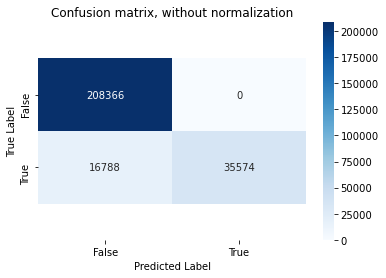

In [119]:
conf_matrix(y_test, y_pred_optimize)

In [144]:
features = pd.DataFrame({'Features':X_train.columns, 'Coeficients':abs(clf_optimize.feature_importances_)}).sort_values(by=['Coeficients'], ascending=False)

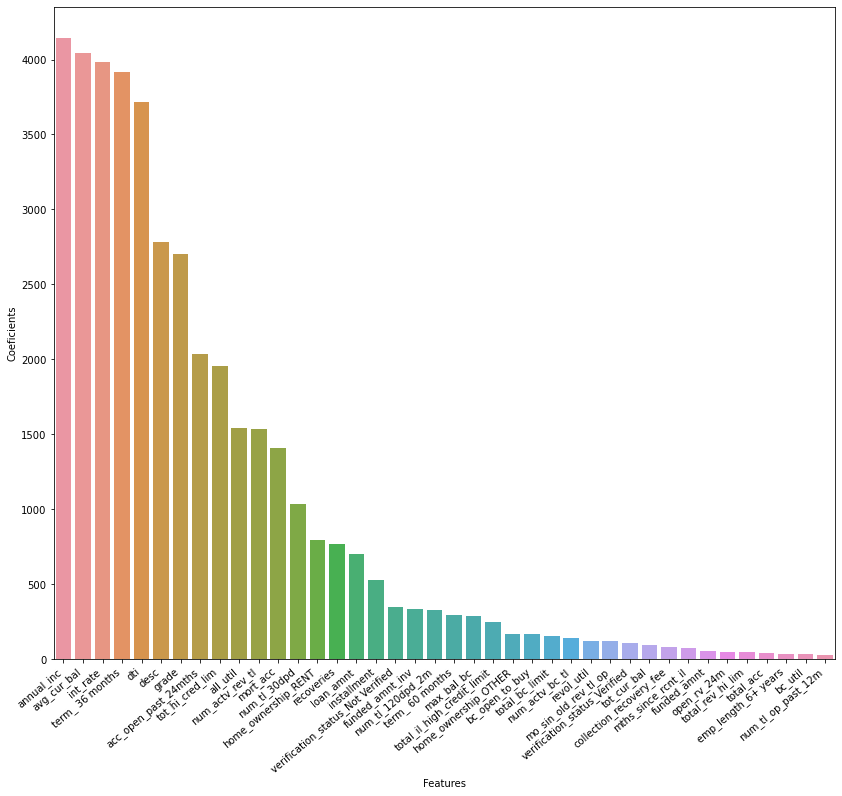

In [145]:
best_features = features.head(40)
fig, ax = plt.subplots(figsize=(14,12))
coef_plot = sns.barplot(best_features['Features'],best_features['Coeficients'])
coef_plot.set_xticklabels(coef_plot.get_xticklabels(), rotation=40, ha="right");

In [120]:
roc_auc_score(y_test, y_pred_optimize)

0.8396929070700125

In [130]:
y_pred_optimize_proba = clf_optimize.predict_proba(X_test)[:,1]

In [133]:
df = pd.DataFrame(list(zip(y_pred_optimize, y_pred_optimize_proba)), 
               columns =['Target', 'Predict']) 
df 

,Target,Predict
0,1,0.770310
1,0,0.186064
2,0,0.284256
3,0,0.271367
4,1,0.770385
...,...,...
260723,0,0.199483
260724,0,0.324760
260725,0,0.206725
260726,0,0.135368


### Kolmogorov-Smirnov metric

In [141]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [142]:
mydf = ks(data=df,target="Target", prob="Predict")

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.769348  0.770785   26040          0     73.20%         0.00%   
2       0.321390  0.769346    9534      16572     26.80%         7.36%   
3       0.259977  0.321388       0      26073      0.00%        11.58%   
4       0.223750  0.259976       0      26072      0.00%        11.58%   
5       0.196675  0.223749       0      26073      0.00%        11.58%   
6       0.178098  0.196675       0      26073      0.00%        11.58%   
7       0.163640  0.178096       0      26072      0.00%        11.58%   
8       0.152444  0.163640       0      26000      0.00%        11.55%   
9       0.138466  0.152443       0      26121      0.00%        11.60%   
10      0.120899  0.138466       0      26098      0.00%        11.59%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             73.20

In [143]:
pd.DataFrame(mydf)

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.769348,0.770785,26040,0,73.20%,0.00%,73.20%,0.00%,73.2
2,0.321390,0.769346,9534,16572,26.80%,7.36%,100.00%,7.36%,92.6
3,0.259977,0.321388,0,26073,0.00%,11.58%,100.00%,18.94%,81.1
4,0.223750,0.259976,0,26072,0.00%,11.58%,100.00%,30.52%,69.5
5,0.196675,0.223749,0,26073,0.00%,11.58%,100.00%,42.10%,57.9
6,0.178098,0.196675,0,26073,0.00%,11.58%,100.00%,53.68%,46.3
7,0.163640,0.178096,0,26072,0.00%,11.58%,100.00%,65.26%,34.7
8,0.152444,0.163640,0,26000,0.00%,11.55%,100.00%,76.81%,23.2
9,0.138466,0.152443,0,26121,0.00%,11.60%,100.00%,88.41%,11.6
